In [156]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
import joblib
from scipy.special import softmax
import sasc.config
import numpy as np
from collections import defaultdict
from copy import deepcopy
import pandas as pd
import sasc.viz
from sasc import analyze_helper
from sasc.modules.fmri_module import convert_module_num_to_voxel_num
from sasc import config
import dvu
dvu.set_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [157]:
pilot_name = 'pilot5_story_data.pkl'

stories_data_dict = joblib.load(
    join(config.RESULTS_DIR, 'processed', pilot_name))
if pilot_name == 'pilot5_story_data.pkl':
    pilot_data_dir = join(config.PILOT_STORY_DATA_DIR, '20240604')

In [158]:
# load responses
default_story_idxs = np.where(
    (np.array(stories_data_dict['story_setting']) == 'roi')
)[0]
resp_np_files = [stories_data_dict['story_name_new'][i].replace('_resps', '')
                 for i in default_story_idxs]
resps_dict = {
    k: np.load(join(pilot_data_dir, k))
    for k in tqdm(resp_np_files)
}

100%|██████████| 4/4 [00:09<00:00,  2.28s/it]


In [162]:
mats = defaultdict(list)
use_clusters = False
voxel_resps_dict = defaultdict(list)
for story_num in default_story_idxs:
    rows = stories_data_dict["rows"][story_num]

    # get resp_chunks
    resp_story = resps_dict[
        stories_data_dict["story_name_new"][story_num].replace(
            '_resps', '')
    ].T  # (voxels, time)
    timing = stories_data_dict["timing"][story_num]
    if 'paragraphs' in stories_data_dict.keys():
        paragraphs = stories_data_dict["paragraphs"][story_num]
    else:
        paragraphs = stories_data_dict["story_text"][story_num].split(
            "\n\n")
    # paragraphs = stories_data_dict["story_text"][story_num].split("\n\n")
    if pilot_name in ['pilot3_story_data.pkl']:
        paragraphs = [sasc.analyze_helper.remove_repeated_words(
            p) for p in paragraphs]
    assert len(paragraphs) == len(
        rows), f"{len(paragraphs)} != {len(rows)}"
    resp_chunks = analyze_helper.get_resps_for_paragraphs(
        timing, paragraphs, resp_story, offset=2)
    assert len(resp_chunks) <= len(paragraphs)

    # calculate mat
    mat = np.zeros((len(rows), len(paragraphs)))
    # mat_dict = {}
    rois = rows['roi'].values
    vox_nums = rows['voxel_nums']
    for i in range(len(resp_chunks)):
        mat[:, i] = [resp_chunks[i][x].mean()
                     for x in rows['voxel_nums']]
        voxel_resps_dict[rois[i]].append(
            resp_chunks[i][vox_nums.iloc[i]].mean(axis=1))
    mat[:, 0] = np.nan  # ignore the first column
    # print('mat', mat)

    args = np.argsort(rows["roi"].values)
    mat = mat[args, :][:, args]
    mats[use_clusters].append(deepcopy(mat))

    # plt.imshow(mat)
    # plt.colorbar(label="Mean response")
    # plt.xlabel("Corresponding paragraph\n(Ideally, diagonal should be brighter)")
    # plt.ylabel("Voxel")
    # plt.show()

if 'voxel_num' in rows.columns:
    rows = rows.sort_values(by="voxel_num")
else:
    rows = rows.sort_values(by="roi")
expls = rows["expl"].values


m = {}
for use_clusters in [False, True]:
    mats[use_clusters] = np.array(mats[use_clusters])  # (6, 17, 17)
    m[use_clusters] = np.nanmean(mats[use_clusters], axis=0)

/tmp/ipykernel_4075044/3474217396.py:61: RuntimeWarning: Mean of empty slice
  m[use_clusters] = np.nanmean(mats[use_clusters], axis=0)


### ROI heatmap full

<>:16: DeprecationWarning: invalid escape sequence '\s'
<>:16: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_4075044/3598464975.py:16: DeprecationWarning: invalid escape sequence '\s'
  m_plot, clab="Mean response ($\sigma$)", clab_size='large')


Body parts Body parts
Descriptive elements of scenes or objects Descriptive elements of scenes or objects
Personal growth and reflection Personal growth and reflection
Direction and location descriptions Direction and location descriptions
Spatial positioning and directions Spatial positioning and directions
Scenes and settings Scenes and settings
Unappetizing foods Unappetizing foods
Travel and location names Travel and location names
Location names Location names
Verbal interactions Verbal interactions
Time and numbers Time and numbers


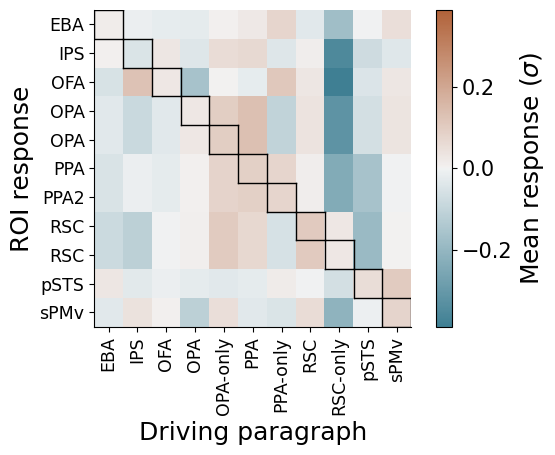

In [163]:
assert pilot_name == 'pilot5_story_data.pkl'
# note: some voxels didn't have good clusters so they will be missing from these plots...
use_clusters = False
m1 = m[use_clusters]

sasc.viz.outline_diagonal(m1.shape, color='black', lw=1, block_size=1)

s = 'small'
# expls_order = analyze_helper.sort_expls_semantically(expls, device='cuda')
rois = rows["roi"].values
expls_order = np.argsort(rois)
m_plot = m1[expls_order][:, expls_order]  # [:, expls_order]

rois = rois[expls_order]
sasc.viz.imshow_diverging(
    m_plot, clab="Mean response ($\sigma$)", clab_size='large')
plt.xlabel("Driving paragraph",  # \n(Ideally, diagonal should be brighter)",
           fontsize='large')

# plt.ylabel("Voxel", fontsize='x-small')
# labs = expls[expls_order]

plt.ylabel("ROI response", fontsize='large')
# labs = [f'{i + 1:02d}' for i in range(len(expls_order))]
labs = expls[expls_order]
for i in range(len(labs)):
    print(labs[i], expls[expls_order[i]])

plt.yticks(labels=[x.replace('_only', '') for x in rois], ticks=np.arange(
    len(expls)), fontsize=s)
plt.xticks(labels=[x.replace('2', '').replace('_', '-') for x in rois], ticks=np.arange(
    len(expls)), rotation=90, fontsize=s)
plt.tight_layout()
plt.savefig(join(config.RESULTS_DIR, 'figs/main',
            pilot_name[:pilot_name.index('_')] + '_roi_heatmap.pdf'), bbox_inches='tight')
plt.show()

In [161]:
m1

nan

### Cleaned up means

In [152]:
roi_voxel_means = {
    k: np.vstack(voxel_resps_dict[k]).mean(axis=0)
    for k in rows['roi']
}

roi_voxel_tups = [
    (k, v)

    for k, l in roi_voxel_means.items()
    for v in l]

# convert tups to dataframe
roi_voxel_df = pd.DataFrame(roi_voxel_tups, columns=['roi', 'voxel_mean'])

<Axes: xlabel='roi', ylabel='voxel_mean'>

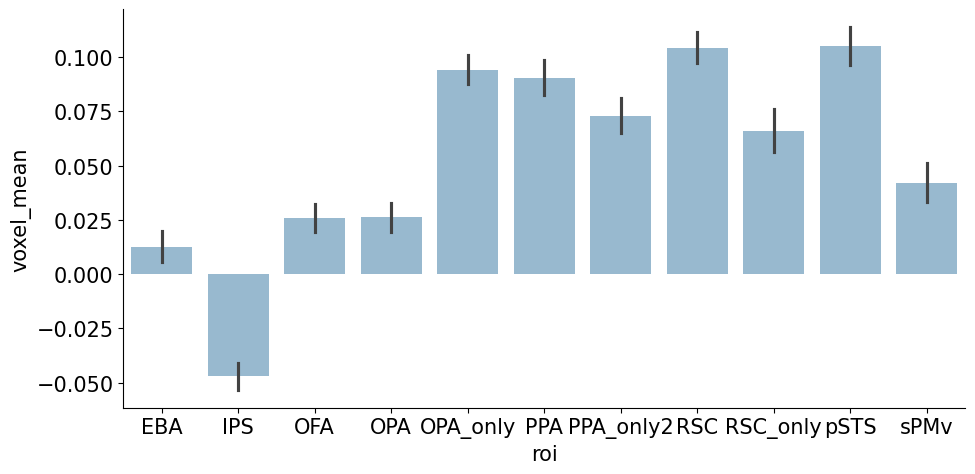

In [177]:
roi_voxel_df

# barplot
plt.figure(figsize=(10, 5))
# sns.stripplot(x='roi', y='voxel_mean', data=roi_voxel_df, color='black', alpha=0.1)
# sns.violinplot(x='roi', y='voxel_mean', data=roi_voxel_df) #, alpha=0.1)
sns.barplot(x='roi', y='voxel_mean', data=roi_voxel_df,
            errorbar='se', alpha=0.5)
# plt.axhline(0)

In [ ]:
len(voxel_resps_dict['sPMv'][0])

In [ ]:
voxel_resps_dict['PPA'][0][1].shape

### Make average plot

In [ ]:
# calculate means
use_clusters = False
m1 = m[use_clusters]
diag_means = np.diag(m1)
off_diag_means = np.nanmean(m1, axis=1) - (diag_means / len(diag_means))
sasc.viz.barplot_default([diag_means], [off_diag_means],
                         pilot_name, expls, annot_points=False)
joblib.dump({'diag_means': diag_means,
            'off_diag_means': off_diag_means}, join(config.RESULTS_DIR, 'processed', pilot_name.replace('_story_data.pkl', '_default_means.pkl')))

In [ ]:
for tup in rows[['roi', 'expl']].values:
    print(tup[0] + ': ', tup[1])

### Story-level differences

In [ ]:
def get_story_df(mats1, melt=False):
    d = defaultdict(list)
    story_names = resp_np_files
    for i in range(len(mats1)):
        m = mats1[i]
        d['driving'].append(np.nanmean(np.diag(m)))
        d['baseline'].append(np.nanmean(m[~np.eye(m.shape[0], dtype=bool)]))
        d['story'].append(story_names[i].replace('.npy', ''))
    d = pd.DataFrame.from_dict(d)
    if melt:
        d = d.melt(id_vars='story', value_vars=[
            'driving', 'baseline'], var_name='condition', value_name='mean')
        d = d[d.condition == 'driving']
    return d


use_clusters = False
mats1 = mats[use_clusters]
story_scores_df = get_story_df(mats1)
joblib.dump(story_scores_df, join(config.RESULTS_DIR, 'processed',
            pilot_name.replace('_story_data.pkl', '_default_story_scores.pkl')))

sasc.viz.stories_barplot(story_scores_df)

### ROI heatmap

<>:16: DeprecationWarning: invalid escape sequence '\s'
<>:16: DeprecationWarning: invalid escape sequence '\s'
/tmp/ipykernel_4075044/3598464975.py:16: DeprecationWarning: invalid escape sequence '\s'
  m_plot, clab="Mean response ($\sigma$)", clab_size='large')
/tmp/ipykernel_4075044/3598464975.py:16: DeprecationWarning: invalid escape sequence '\s'
  m_plot, clab="Mean response ($\sigma$)", clab_size='large')


IndexError: tuple index out of range

### ROI heatmap truncated

In [ ]:
assert pilot_name == 'pilot5_story_data.pkl'
# note: some voxels didn't have good clusters so they will be missing from these plots...
use_clusters = False
m1 = m[use_clusters]

sasc.viz.outline_diagonal(m1.shape, color='black', lw=1, block_size=1)

s = 'medium'
# expls_order = analyze_helper.sort_expls_semantically(expls, device='cuda')
rois = rows["roi"].values
expls_order = np.argsort(rois)

# remove idxs where roi is not in ['OPA-only', 'RSC-only']
expls_order = expls_order[np.where(
    np.array([x in ['OPA_only', 'RSC_only', 'PPA_only2'] for x in rois[expls_order]]) == True)[0]]
print(expls_order)


m_plot = m1[expls_order][:, expls_order]  # [:, expls_order]


rois = rois[expls_order]
sasc.viz.imshow_diverging(
    m_plot, clab="Mean response ($\sigma$)", clab_size='large')
plt.xlabel("Driving paragraph",  # \n(Ideally, diagonal should be brighter)",
           fontsize='large')

# plt.ylabel("Voxel", fontsize='x-small')
# labs = expls[expls_order]

plt.ylabel("ROI response", fontsize='large')
# labs = [f'{i + 1:02d}' for i in range(len(expls_order))]
labs = expls[expls_order]
for i in range(len(labs)):
    print(labs[i], expls[expls_order[i]])

plt.yticks(labels=[x.replace('_only', '').replace('2', '') for x in rois], ticks=np.arange(
    len(rois)), fontsize=s)
plt.xticks(labels=[x.replace('2', '').replace('_', '-') for x in rois], ticks=np.arange(
    len(rois)), rotation=90, fontsize=s)
plt.tight_layout()
plt.savefig(join(config.RESULTS_DIR, 'figs/main',
            pilot_name[:pilot_name.index('_')] + '_roi_heatmap.pdf'), bbox_inches='tight')
plt.show()

In [ ]:
m_plot